# Modelling Background Data
This notebook attempts to use some basic functions and fitting algorithms to have an analytical function to describe the LHCb background data.

## Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utilities import Data, Cut, Consts

In [2]:
RFNAME, RSUFFIX = Consts().get_real_tuple()
SFNAME, SSUFFIX = Consts().get_simulated_tuple()
d, s = Data(RFNAME, RSUFFIX), Data(SFNAME, SSUFFIX)
df = d.fetch_features(['Lb_M'])
sf = s.fetch_features(['Lb_M'])

## Visualise Data

In [3]:
low_mass_limit, high_mass_limit = 4500, 6500
no_bins = 200

bins = np.linspace(low_mass_limit, high_mass_limit, no_bins + 1)
bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]

df = df[df['Lb_M'].between(low_mass_limit, high_mass_limit)]
sf = sf[sf['Lb_M'].between(low_mass_limit, high_mass_limit)]

f1, _ = np.histogram(df['Lb_M'], bins=bins)
f2, _ = np.histogram(sf['Lb_M'], bins=bins)
err1, err2 = np.sqrt(f1), np.sqrt(f2)

d1 = np.array([bin_centres, f1, err1]).T
d2 = np.array([bin_centres, f2, err2]).T

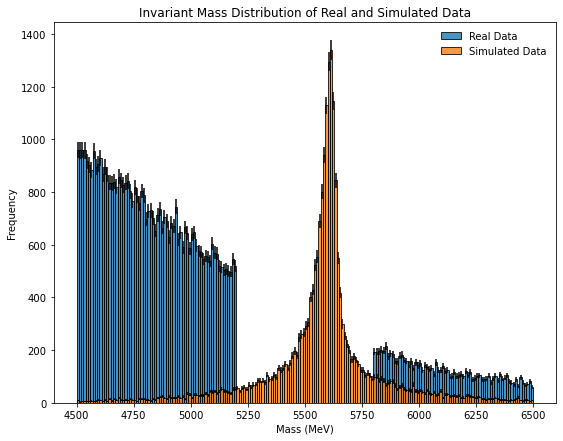

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Real Data', edgecolor='k', alpha=0.8)
ax.bar(d2[:,0], d2[:,1], width=bin_width, yerr=d2[:,2], label='Simulated Data', edgecolor='k', alpha=0.8)
ax.set_xlabel('Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.title('Invariant Mass Distribution of Real and Simulated Data')
plt.savefig('/home/user211/project/images/initial_mass_distribution_errs.png', dpi=800)

## Fit Polynomials

In [5]:
import bgfuncs as bf
from scipy.optimize import curve_fit

d1 = d1[(d1[:,1] != 0)]
x, y, yerr = d1[:,0], d1[:,1], d1[:,2]
# Curve fit can take errors which then performs a standard chi-square minimisation

popt1, pcov1 = curve_fit(bf.quadratic, x, y, [1, 1, 1], yerr, absolute_sigma=True)
popt2, pcov2 = curve_fit(bf.cubic, x, y, [1, 1, 1, 1], yerr, absolute_sigma=True)
popt3, pcov3 = curve_fit(bf.quartic, x, y, [1, 1, 1, 1, 1], yerr, absolute_sigma=True)

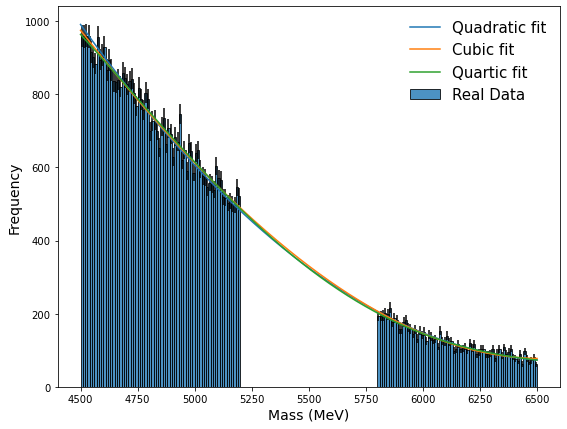

In [13]:


fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Real Data', edgecolor='k', alpha=0.8)

ax.plot(func_x, bf.quadratic(func_x, *popt1), label='Quadratic fit')
ax.plot(func_x, bf.cubic(func_x, *popt2), label='Cubic fit')
ax.plot(func_x, bf.quartic(func_x, *popt3), label='Quartic fit')

ax.set_xlabel('Mass (MeV)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.legend(frameon=False, prop={'size': 15})
#plt.title('Invariant Mass Distribution of Real and Simulated Data')
#plt.savefig('/home/user211/project/images/BackgroundFits/AllFits.png', dpi=800)
plt.show()

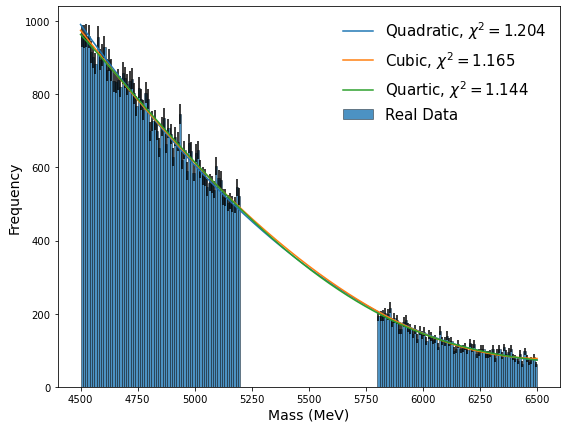

In [53]:
def chi_square_dof(model, params, data, significane=0.05):
    """
    Calculate the chi-squared per degree of freedom for some data and a model
    
    Returns
    -------
    chi_square_dof : float
        The value of the chi squared per degrees of freedom statistic for
        the distribution under test. 
    
    accept_model : bool
        Whether to accept (true) or reject (false) the model based on the
        chi-squared statistic calculated and the significance level. By
        default this is a 5% two-tailed test. 
    """
    from scipy.stats import chi2
    df = len(data[:,0]) - len(params)
    test_value = chi2.ppf(1-significane, df)/df
    chi_square = np.sum(((data[:,1]-model(data[:,0], *params))/data[:,2])**2) 
    chi_squared_dof = chi_square/df
    return chi_squared_dof, chi_squared_dof < test_value

quadratic_chi = chi_square_dof(bf.quadratic, popt1, d1)[0]
cubic_chi = chi_square_dof(bf.cubic, popt2, d1)[0]
quartic_chi = chi_square_dof(bf.quartic, popt3, d1)[0]

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
func_x = np.linspace(low_mass_limit, high_mass_limit, 500)
ax.bar(d1[:,0], d1[:,1], width=bin_width, yerr=d1[:,2], label='Real Data', edgecolor='k', linewidth=0.5, alpha=0.8)
ax.plot(func_x, bf.quadratic(func_x, *popt1), label=rf'Quadratic, $\chi^2={quadratic_chi:.3f}$')
ax.plot(func_x, bf.cubic(func_x, *popt2), label=rf'Cubic, $\chi^2={cubic_chi:.3f}$')
ax.plot(func_x, bf.quartic(func_x, *popt3), label=rf'Quartic, $\chi^2={quartic_chi:.3f}$')
ax.set_xlabel('Mass (MeV)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
plt.legend(frameon=False, prop={'size': 15})
#plt.title('Invariant Mass Distribution of Real and Simulated Data')
plt.savefig('/home/user211/project/images/BackgroundFits/PolyFitsWithChiSquare.png', dpi=800)
plt.show()